In [1]:
import numpy as np 
import pandas as pd 

from scipy import stats
import math

from string import punctuation
import re

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

pd.set_option('max_columns', 200)
pd.set_option('max_rows', 80)

In [2]:
df_train = pd.read_csv('../data_raw/train.csv', dtype={'WindSpeed': 'object'})

df_train.head()

,GameId,PlayId,Team,X,Y,S,A,Dis,Orientation,Dir,NflId,DisplayName,JerseyNumber,Season,YardLine,Quarter,GameClock,PossessionTeam,Down,Distance,FieldPosition,HomeScoreBeforePlay,VisitorScoreBeforePlay,NflIdRusher,OffenseFormation,OffensePersonnel,DefendersInTheBox,DefensePersonnel,PlayDirection,TimeHandoff,TimeSnap,Yards,PlayerHeight,PlayerWeight,PlayerBirthDate,PlayerCollegeName,Position,HomeTeamAbbr,VisitorTeamAbbr,Week,Stadium,Location,StadiumType,Turf,GameWeather,Temperature,Humidity,WindSpeed,WindDirection
0,2017090700,20170907000118,away,73.91,34.84,1.69,1.13,0.40,81.99,177.18,496723,Eric Berry,29,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08T00:44:06.000Z,2017-09-08T00:44:05.000Z,8,6-0,212,12/29/1988,Tennessee,SS,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
1,2017090700,20170907000118,away,74.67,32.64,0.42,1.35,0.01,27.61,198.70,2495116,Allen Bailey,97,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08T00:44:06.000Z,2017-09-08T00:44:05.000Z,8,6-3,288,03/25/1989,Miami,DE,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
2,2017090700,20170907000118,away,74.00,33.20,1.22,0.59,0.31,3.01,202.73,2495493,Justin Houston,50,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08T00:44:06.000Z,2017-09-08T00:44:05.000Z,8,6-3,270,01/21/1989,Georgia,DE,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
3,2017090700,20170907000118,away,71.46,27.70,0.42,0.54,0.02,359.77,105.64,2506353,Derrick Johnson,56,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08T00:44:06.000Z,2017-09-08T00:44:05.000Z,8,6-3,245,11/22/1982,Texas,ILB,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
4,2017090700,20170907000118,away,69.32,35.42,1.82,2.43,0.16,12.63,164.31,2530794,Ron Parker,38,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08T00:44:06.000Z,2017-09-08T00:44:05.000Z,8,6-0,206,08/17/1987,Newberry,FS,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW


In [4]:
def list_missing(data, verbose=True):
    mis_cols = [col for col in data.columns if data[col].isna().any()]
    if not verbose:
        return mis_cols
    tot_rows = len(data)
    for col in mis_cols:
        print(f'Column {col}: {round(data[col].isna().sum()*100/tot_rows, 4)}% missing')
    return mis_cols

mis_cols = list_missing(df_train)

Column Orientation: 0.0035% missing
Column Dir: 0.0027% missing
Column FieldPosition: 1.2602% missing
Column OffenseFormation: 0.0216% missing
Column DefendersInTheBox: 0.0129% missing
Column StadiumType: 6.4607% missing
Column GameWeather: 8.5624% missing
Column Temperature: 9.5205% missing
Column Humidity: 1.2084% missing
Column WindSpeed: 13.2277% missing
Column WindDirection: 15.7395% missing


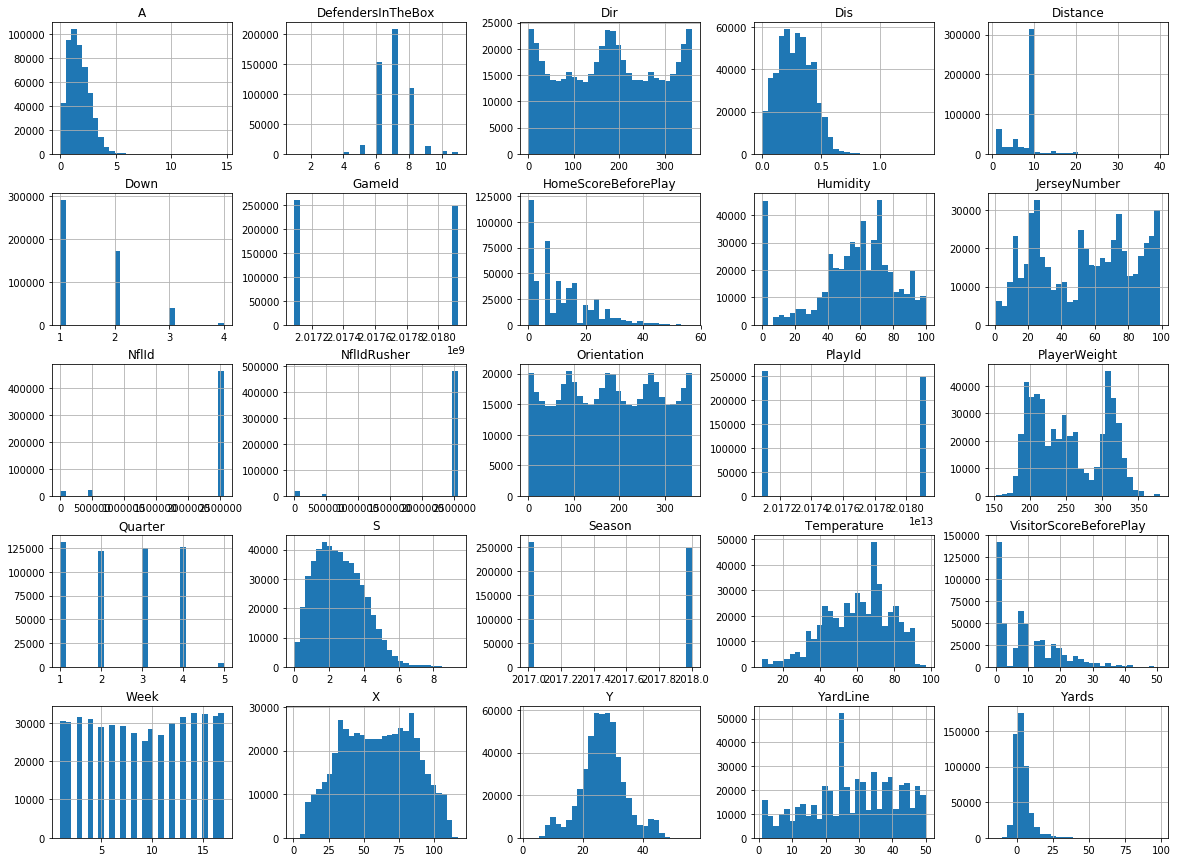

In [5]:
df_train.hist(bins=30, figsize=(20,15))
plt.show()

In [25]:
def clean_columns(data):
    cols = ['DisplayName', 'JerseyNumber', 'Season', 
            'PlayerCollegeName', 'Week', 'Stadium']
    data.drop(cols, axis=1, inplace=True)
    return data


def clean_team_names(data):
    data.loc[data.VisitorTeamAbbr == "ARI", 'VisitorTeamAbbr'] = "ARZ"
    data.loc[data.HomeTeamAbbr == "ARI", 'HomeTeamAbbr'] = "ARZ"

    data.loc[data.VisitorTeamAbbr == "BAL", 'VisitorTeamAbbr'] = "BLT"
    data.loc[data.HomeTeamAbbr == "BAL", 'HomeTeamAbbr'] = "BLT"

    df_train.loc[data.VisitorTeamAbbr == "CLE", 'VisitorTeamAbbr'] = "CLV"
    df_train.loc[data.HomeTeamAbbr == "CLE", 'HomeTeamAbbr'] = "CLV"

    data.loc[data.VisitorTeamAbbr == "HOU", 'VisitorTeamAbbr'] = "HST"
    data.loc[data.HomeTeamAbbr == "HOU", 'HomeTeamAbbr'] = "HST"
    
    return data


def clean_turf(data):
    Turf = {'Field Turf':'Artificial','A-Turf Titan':'Artificial', 
            'Grass':'Natural', 'UBU Sports Speed S5-M':'Artificial', 
            'Artificial':'Artificial', 'DD GrassMaster':'Artificial', 
            'Natural Grass':'Natural', 'UBU Speed Series-S5-M':'Artificial', 
            'FieldTurf':'Artificial', 'FieldTurf 360':'Artificial', 
            'Natural grass':'Natural', 'grass':'Natural', 
            'Natural':'Natural', 'Artifical':'Artificial', 
            'FieldTurf360':'Artificial', 'Naturall Grass':'Natural', 
            'Field turf':'Artificial', 'SISGrass':'Artificial', 
            'Twenty-Four/Seven Turf':'Artificial', 'natural grass':'Natural'}
    data['Turf'] = data['Turf'].map(Turf)
    data['Turf'] = (data['Turf'] == 'Natural').astype(int)
    return data


def clean_heights(data):
    tmp = data.PlayerHeight.str.split('-', expand=True)
    data['PlayerHeight'] = tmp[0].astype(int)*12 + tmp[1].astype(int)
    return data


def x_y_speed(data):
    data['X_speed'] = data.S * np.sin(data.Dir)
    data['Y_speed'] = data.S * np.cos(data.Dir)
    return data


def x_y_acceleration(data):
    data['X_acceleration'] = data.A * np.sin(data.Dir)
    data['Y_acceleration'] = data.A * np.cos(data.Dir)
    return data


def player_age(data):
    data['age'] = (pd.to_datetime(pd.to_datetime(data.TimeSnap).dt.date) - 
                   pd.to_datetime(data.PlayerBirthDate)).dt.days
    data.drop(['TimeSnap', 'PlayerBirthDate', 'TimeHandoff'], axis=1, inplace=True)
    return data


def standardize_plays(data):
    data['to_left'] = data.PlayDirection == "left"
    data['has_ball'] = data.NflId == data.NflIdRusher
    data['offense_team'] = 'home'
    data.loc[data.PossessionTeam != data.HomeTeamAbbr, 'offense_team'] = 'away'
    
    data.loc[data.to_left, 'X'] = 120 - data.X
    data.loc[data.to_left, 'Y'] = 160/3 - data.Y
    
    data['Dir'] = np.mod(90 - data.Dir, 360) * math.pi/180.0
    data.loc[data.to_left, 'Dir'] = np.mod(np.pi + data.loc[data.to_left, 'Dir'], 2*np.pi)
    
    which_side = data.FieldPosition != data.PossessionTeam
    data.loc[which_side, 'YardLine'] = 100 - data.YardLine
    data.YardLine = data.YardLine + 10
    
    data['from_yardline'] = abs(data['YardLine'] - data['X'])
    
    return data


def distance_from_ball(data):
    data = data[['X', 'Y', 'has_ball', 'Team']].copy()
    X_ball, Y_ball = data[data.has_ball].X.values[0], data[data.has_ball].Y.values[0]
    team_ball = data[data.has_ball].Team.values[0]
    data['distance_from_ball'] = np.sqrt((data.X - X_ball)**2 + (data.Y - Y_ball)**2)
    data['closest_opponent'] = data[data.Team != team_ball].distance_from_ball.min()
    data.loc[(data.Team != team_ball) & (data.distance_from_ball < 6), 'in_6yd'] = 1
    data['opponents_in_6'] = data.in_6yd.fillna(0).sum()
    del data['in_6yd']
    data.loc[(data.Team == team_ball) & (data.distance_from_ball < 6), 'in_6yd'] = 1
    data['teammates_in_6'] = data.in_6yd.fillna(0).sum()
    del data['in_6yd']
    return data


def by_play_distances(data):
    tmp = data.groupby('PlayId').apply(distance_from_ball).reset_index()
    tmp.drop(['level_1'], axis=1, inplace=True)
    data = pd.merge(data, tmp, on=['PlayId', 'X', 'Y', 'has_ball', 'Team'], how='left')
    return data


def prepare_data(data):
    data = clean_columns(data)
    data = clean_team_names(data)
    data = clean_turf(data)
    data = standardize_plays(data)
    data = clean_heights(data)
    data = x_y_speed(data)
    data = x_y_acceleration(data)
    data = player_age(df_train)
    data = by_play_distances(data)
    return data

In [27]:
df_processed = prepare_data(df_train)

df_processed.head()

,GameId,PlayId,Team,X,Y,S,A,Dis,Orientation,Dir,NflId,YardLine,Quarter,GameClock,PossessionTeam,Down,Distance,FieldPosition,HomeScoreBeforePlay,VisitorScoreBeforePlay,NflIdRusher,OffenseFormation,OffensePersonnel,DefendersInTheBox,DefensePersonnel,PlayDirection,Yards,PlayerHeight,PlayerWeight,Position,HomeTeamAbbr,VisitorTeamAbbr,Location,StadiumType,Turf,GameWeather,Temperature,Humidity,WindSpeed,WindDirection,to_left,has_ball,offense_team,from_yardline,X_speed,Y_speed,X_acceleration,Y_acceleration,age,distance_from_ball,closest_opponent,opponents_in_6,teammates_in_6
0,2017090700,20170907000118,away,46.09,18.493333,1.69,1.13,0.40,81.99,1.620015,496723,45,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,8,72,212,SS,NE,KC,"Foxborough, MA",Outdoor,0,Clear and warm,63.0,77.0,8,SW,True,False,home,1.09,1.687953,-0.083145,1.128632,-0.055594,10480,6.480872,4.59331,3.0,7.0
1,2017090700,20170907000118,away,45.33,20.693333,0.42,1.35,0.01,27.61,1.244420,2495116,45,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,8,75,288,DE,NE,KC,"Foxborough, MA",Outdoor,0,Clear and warm,63.0,77.0,8,SW,True,False,home,0.33,0.397828,0.134657,1.278734,0.432828,10394,4.593310,4.59331,3.0,7.0
2,2017090700,20170907000118,away,46.00,20.133333,1.22,0.59,0.31,3.01,1.174083,2495493,45,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,8,75,270,DE,NE,KC,"Foxborough, MA",Outdoor,0,Clear and warm,63.0,77.0,8,SW,True,False,home,1.00,1.125250,0.471395,0.544178,0.227970,10457,5.448982,4.59331,3.0,7.0
3,2017090700,20170907000118,away,48.54,25.633333,0.42,0.54,0.02,359.77,2.868623,2506353,45,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,8,75,245,ILB,NE,KC,"Foxborough, MA",Outdoor,0,Clear and warm,63.0,77.0,8,SW,True,False,home,3.54,0.113229,-0.404449,0.145580,-0.520006,12709,7.820038,4.59331,3.0,7.0
4,2017090700,20170907000118,away,50.68,17.913333,1.82,2.43,0.16,12.63,1.844638,2530794,45,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,8,72,206,FS,NE,KC,"Foxborough, MA",Outdoor,0,Clear and warm,63.0,77.0,8,SW,True,False,home,5.68,1.752185,-0.492187,2.339456,-0.657151,10980,10.622476,4.59331,3.0,7.0


In [30]:
df_processed.to_csv('../data_processed/train_processed.csv', index=False)